In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [3]:
dataframe = pd.read_csv('C:\\Users\\fgene\\OneDrive\\Documents\\Hipparcos.csv')

In [4]:
dataset = dataframe.copy()
dataset.tail()

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,ePlx,BV,VI
1500,13129,7.74,42.218118,-46.346979,15.17,27.24,16.33,0.71,0.490,0.56
1501,13133,6.26,42.231273,69.634199,15.99,2.89,37.47,0.62,0.151,0.17
1502,13141,5.25,42.255696,-62.806592,19.73,94.53,29.02,0.49,0.101,0.11
1503,13142,8.07,42.258362,58.029059,15.77,135.45,-135.77,1.19,0.604,0.67
1504,13147,4.45,42.272331,-32.406284,19.31,86.96,158.96,0.67,0.981,1.00


In [5]:
dataset.isna().sum()

HIP     0
Vmag    0
RA      0
DE      0
Plx     0
pmRA    0
pmDE    0
ePlx    0
BV      0
VI      0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

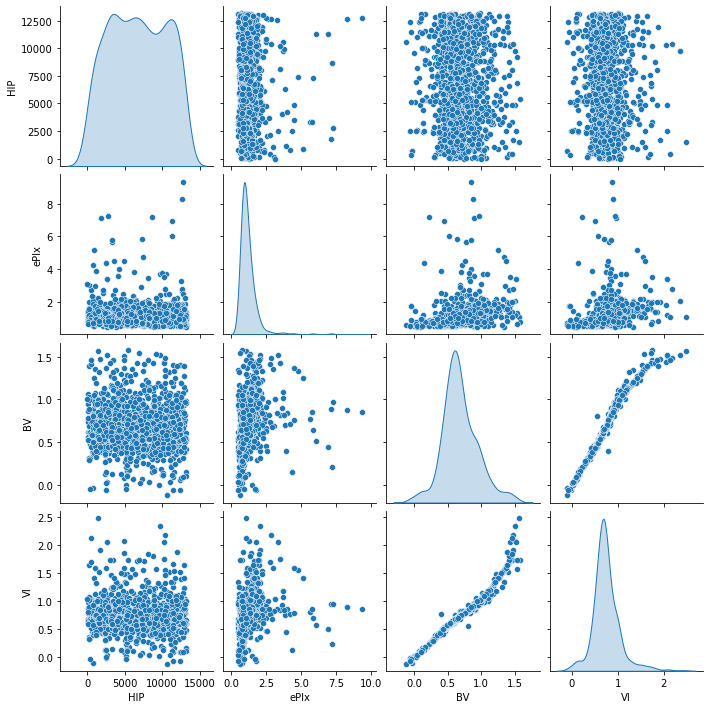

In [12]:
sns.pairplot(train_dataset[['HIP', 'ePlx', 'BV', 'VI']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HIP,1204.0,6727.421927,3762.638539,2.000000,3499.500000,6641.000000,10074.500000,13147.000000
Vmag,1204.0,7.817176,1.564672,2.010000,6.917500,7.995000,8.940000,10.500000
RA,1204.0,21.612573,12.148752,0.003797,11.167658,21.295730,32.405806,42.272331
DE,1204.0,-3.950789,39.827549,-85.891525,-34.021654,-5.005068,25.799376,86.933066
Plx,1204.0,24.132907,18.725947,13.340000,15.710000,18.980000,25.157500,280.270000
pmRA,1204.0,116.250357,303.992661,-1761.070000,-14.310000,84.335000,181.262500,5634.070000
pmDE,1204.0,-56.194311,169.743671,-2337.940000,-104.672500,-39.890000,14.522500,1442.500000
ePlx,1204.0,1.204651,0.753873,0.470000,0.840000,1.030000,1.340000,9.330000
BV,1204.0,0.681615,0.268658,-0.120000,0.520750,0.646000,0.830000,1.576000
VI,1204.0,0.746047,0.298725,-0.110000,0.590000,0.710000,0.860000,2.480000


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('BV')
test_labels = test_features.pop('BV')

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
HIP,6727.421927,3762.638539
Vmag,7.817176,1.564672
RA,21.612573,12.148752
DE,-3.950789,39.827549
Plx,24.132907,18.725947
pmRA,116.250357,303.992661
pmDE,-56.194311,169.743671
ePlx,1.204651,0.753873
BV,0.681615,0.268658
VI,0.746047,0.298725


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [17]:
normalizer.adapt(np.array(train_features))

In [18]:
print(normalizer.mean.numpy())

[[6727.421    7.817   21.613   -3.951   24.133  116.25   -56.194    1.205
     0.746]]


In [19]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[8497.      4.66   27.4   -10.69   42.35 -148.9   -94.47    0.87    0.38]]

Normalized: [[ 0.47 -2.02  0.48 -0.17  0.97 -0.87 -0.23 -0.44 -1.23]]


In [20]:
VI = np.array(train_features['VI'])

VI_normalizer = layers.Normalization(input_shape=[1,], axis=None)
VI_normalizer.adapt(VI)

In [21]:
VI_model = tf.keras.Sequential([
    VI_normalizer,
    layers.Dense(units=1)
])

VI_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [22]:
VI_model.predict(VI[:10])

array([[ 1.009],
       [-0.783],
       [-0.783],
       [-0.948],
       [-0.149],
       [-1.031],
       [-0.094],
       [ 0.706],
       [ 0.761],
       [ 0.485]], dtype=float32)

In [23]:
VI_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [24]:
%%time
history = VI_model.fit(
    train_features['VI'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 3.66 s


In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.030662,0.030411,95
96,0.029711,0.039104,96
97,0.034577,0.033142,97
98,0.033585,0.036997,98
99,0.038964,0.042138,99


In [26]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [BV]')
  plt.legend()
  plt.grid(True)

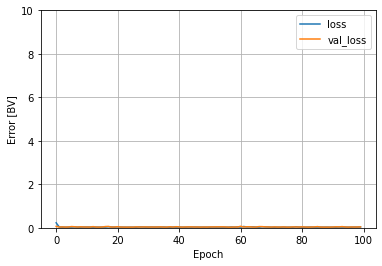

In [27]:
plot_loss(history)

In [28]:
test_results = {}

test_results['VI_model'] = VI_model.evaluate(
    test_features['VI'],
    test_labels, verbose=0)

In [35]:
x = tf.linspace(0.0, 5, 6)
y = VI_model.predict(x)

In [36]:
def plot_VI(x, y):
  plt.scatter(train_features['VI'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('VI')
  plt.ylabel('BV')
  plt.legend()

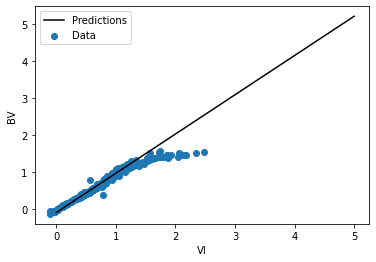

In [37]:
plot_VI(x, y)

In [38]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [39]:
linear_model.predict(train_features[:10])

array([[-0.418],
       [ 0.287],
       [-1.802],
       [ 0.134],
       [ 0.862],
       [ 0.035],
       [ 1.306],
       [ 1.102],
       [ 0.202],
       [ 1.606]], dtype=float32)

In [40]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.081],
       [ 0.449],
       [ 0.161],
       [ 0.761],
       [-0.322],
       [-0.067],
       [ 0.593],
       [ 0.041],
       [-0.742]], dtype=float32)>

In [41]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [42]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 3.37 s


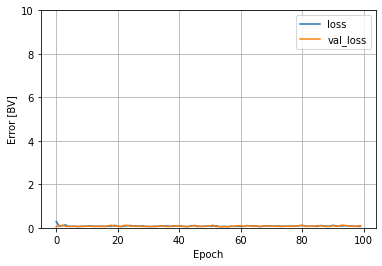

In [43]:
plot_loss(history)

In [44]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [45]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [46]:
dnn_VI_model = build_and_compile_model(VI_normalizer)

In [47]:
dnn_VI_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [48]:
%%time
history = dnn_VI_model.fit(
    train_features['VI'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.69 s


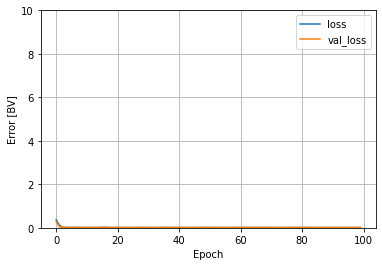

In [49]:
plot_loss(history)

In [51]:
x = tf.linspace(0.0, 5, 6)
y = dnn_VI_model.predict(x)

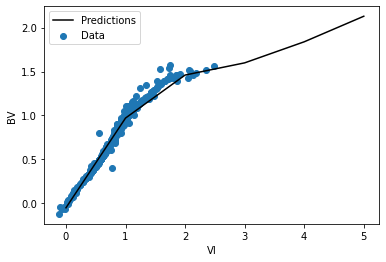

In [52]:
plot_VI(x, y)

In [53]:
test_results['dnn_VI_model'] = dnn_VI_model.evaluate(
    test_features['VI'], test_labels,
    verbose=0)

In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.82 s


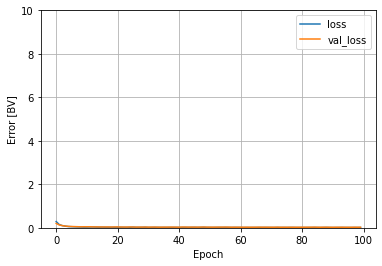

In [56]:
plot_loss(history)

In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [BV]']).T

,Mean absolute error [BV]
VI_model,0.038428
linear_model,0.107243
dnn_VI_model,0.015005
dnn_model,0.025021


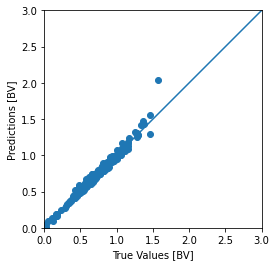

In [62]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [BV]')
plt.ylabel('Predictions [BV]')
lims = [0, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

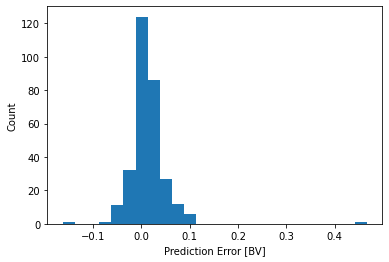

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [BV]')
_ = plt.ylabel('Count')